# Introduction
이번에는 강의에서 다뤘던 내용 중 learning rate와 딥러닝 최적화에 대해 알아보겠습니다.

이 노트북에서는 아래와 같은 내용들을 다룹니다.
- Keras
- Learning Rate
- Learning Rate Schedule

## Import

In [ ]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow import keras

seed = 777
np.random.seed(seed)
tf.random.set_random_seed(seed) # for reproducibility

## Dataset 준비
이번에도 역시 fashion MNIST를 사용하도록 하겠습니다.

In [ ]:
(x_train, y_train), (x_test, y_test) = keras.datasets.fashion_mnist.load_data()
x_train = x_train.astype(np.float32) / 255.
y_train = y_train.astype(np.int64)
x_test = x_test.astype(np.float32) / 255.
y_test = y_test.astype(np.int64)

print(f"input shape: {x_train.shape}")
print(f"label shape: {y_train.shape}")

## Keras
Keras는 딥러닝 비전문가라도 각자 분야에서 손쉽게 딥러닝 모델을 개발하고 활용할 수 있도는 직관적인 API를 제공합니다.

내부적으로는 텐서플로우(TensorFlow), 티아노(Theano), CNTK 등의 딥러닝 전용 엔진이 구동되지만 케라스 사용자는 복잡한 내부 엔진을 알 필요는 없습니다. 

현재 Tensorflow에서 공식 api로 지원하고 있으며 손쉬운 사용 덕분에 편리하게 딥러닝 모델을 개발할 수 있습니다.

이전 실습에서 사용한 모델을 다음과 같이 쉽게 만들 수 있습니다.

In [ ]:
model = keras.Sequential([
    keras.layers.Flatten(input_shape=(28, 28)),
    keras.layers.Dense(100, activation=tf.nn.relu), # Fully connected layer
    keras.layers.Dense(100, activation=tf.nn.relu),
    keras.layers.Dense(10, activation=tf.nn.softmax)
])
initial_weight = model.get_weights()
model.summary()

optimizer, loss, performance metric 등도 compile을 통해 쉽게 설정할 수 있습니다. 
학습 과정도 fit을 이용해서 간단히 수행됩니다.

compile과 fit에 대한 자세한 설명은 [Keras docs](https://keras.io/models/model)를 참고하세요.

In [ ]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
hist = model.fit(x_train, y_train, batch_size=1024, epochs=5,
          validation_data=(x_test, y_test))

In [ ]:
# test data evaluation
test_loss, test_accuracy = model.evaluate(x_test, y_test)
print("Test accuracy: {:.4f}".format(test_accuracy))

## Plot History
fit은 학습 과정을 epoch단위로 기록한 history를 리턴합니다.

In [ ]:
%matplotlib inline
def plot_fn(labels, train_loss_histories, train_acc_histories, test_acc_histories):
    fig = plt.figure(figsize=(18,5))
    ax1 = fig.add_subplot(1, 3, 1)
    ax2 = fig.add_subplot(1, 3, 2)
    ax3 = fig.add_subplot(1, 3, 3)
    for label, train_loss_history, train_acc_history, test_acc_history in zip(labels, train_loss_histories, train_acc_histories, test_acc_histories):
        ax1.plot(train_loss_history, label=str(label))
        ax2.plot(train_acc_history, label=str(label))
        ax3.plot(test_acc_history, label=str(label))
        
    ax1.set_xlabel('Batch #')
    ax1.set_ylabel('Training Loss [entropy]')
    ax2.set_xlabel('Batch #')
    ax2.set_ylabel('Training Accuracy')
    ax3.set_xlabel('Batch #')
    ax3.set_ylabel('Test Accuracy')
    plt.legend()
    plt.show
plot_fn(['MNIST'], [hist.history['loss']], [hist.history['acc']], [hist.history['val_acc']])

# Learning rate
learning rate는 학습에 직접적인 영향을 끼치는 매우 중요한 하이퍼 파라미터입니다.
너무 크면 학습이 아예 안될 수 있고 너무 작으면 학습이 너무 느리게 진행될 수 있기 때문에 적당한 learning rate를 설정하는 것이 중요합니다.
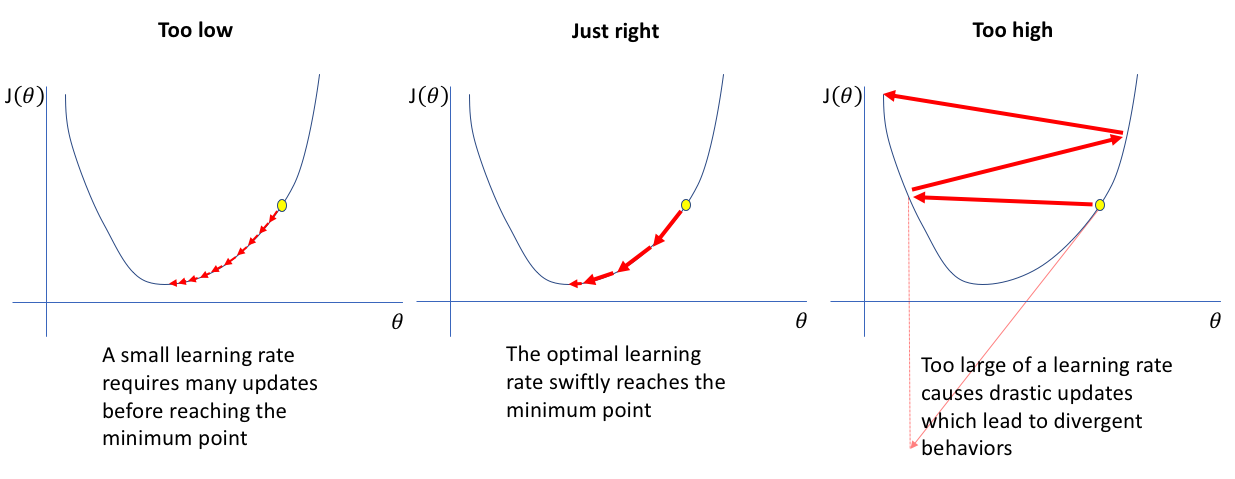

In [ ]:
learning_rates = [10**(-i) for i in range(1,6)]

train_loss_histories = []
train_acc_histories = []
test_acc_histories = []
for learning_rate in learning_rates:
    # optimizer
    optimizer = keras.optimizers.Adam(lr=learning_rate)
    # model setting
    model.set_weights(initial_weight) 
    model.compile(optimizer=optimizer,
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    # training
    hist = model.fit(x_train, y_train, batch_size=1024, epochs=100,
              validation_data=(x_test, y_test), verbose=0) # verbose=0 -> silent during traning
    # evaluation
    test_loss, test_accuracy = model.evaluate(x_test, y_test, verbose=0)
    print("Learning rate: {}".format(learning_rate))
    print("Test accuracy: {:.4f}".format(test_accuracy))
    
    train_loss_histories.append(hist.history['loss'])
    train_acc_histories.append(hist.history['acc'])
    test_acc_histories.append(hist.history['val_acc'])
    
plot_fn([str(lr) for lr in learning_rates], train_loss_histories, train_acc_histories, test_acc_histories)

# Learning rate Schedule
학습이 길어질 경우 학습 중간에 learning rate를 조정하는 것도 중요합니다.
learning rate가 줄어들 수록 local minimum에 더 가깝게 수렴하기 때문에 어느 정도 학습이 된 이후에는 learning rate를 줄이는 것이 학습에 도움이 됩니다.(learning rate decay)
learning rate가 계속 작을 경우 나쁜 local minimum에서 빠져나오지 못할 수 있기 때문에 주기적으로 learning rate를 다시 올려주는 scheduling 기법도 있습니다.

학습 진도에 따라 learning rate를 어떻게 Scheduling하냐에 따라 다양한 learning rate decay 방법이 있습니다.
학습 커브를 비교하면서 강의 자료에 나와있는 Learning Rate Schedule을 구현해보세요.

[참고1](https://pytorch.org/docs/stable/optim.html#torch.optim.lr_scheduler.CosineAnnealingLR)
[참고2](https://keras.io/callbacks)

In [ ]:
def schedule(epoch, lr):
    # lr: current learning rate
    #@TODO: learning rate decay 구현
    new_lr = lr
    if epoch > 0 and epoch % 30 == 0:
        new_lr = lr * 0.5
    return new_lr
# LR Scheduler
lr_scheuler = keras.callbacks.LearningRateScheduler(schedule, verbose=0)

optimizer = keras.optimizers.Adam(lr=1e-3)
model.set_weights(initial_weight)
model.compile(optimizer=optimizer,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
hist = model.fit(x_train, y_train, batch_size=1024, epochs=100,
                 validation_data=(x_test, y_test), 
                 callbacks=[lr_scheuler])

In [ ]:
plot_fn(['LR Decay'], [hist.history['loss']], [hist.history['acc']], [hist.history['val_acc']])

본 실습에서는 간단한 데이터와 모델을 사용하기 때문에 learning rate decay 기법이 큰 효과가 없습니다.
하지만 크고 복잡한 데이터와 모델에서는 효과적일 때가 많습니다.